In [0]:
import numpy as np
import re
import pandas as pd
import random
import unicodedata
import torch  
import torchtext
from torchtext.data import TabularDataset, Field
from torchtext import data, datasets
import torch.nn as nn
import torch.nn.functional as F
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import time
nltk.download('stopwords')
#Create an equally balanced training and testing dataset
#Create CSV of each dataset
#Take 
#Randomizing the training might mean not enough training on certain text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
!pip install chart_studio
import chart_studio

In [0]:
ps=PorterStemmer()
stopwords=set(stopwords.words('english'))
# Define function for data mining
def normalize_reviews(review):
    #Remove numbers
    s = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", review)
    #Remove special characters/whitespaces
    data_special=re.sub(r'[^a-zA-Z0-9\s]','',s)
    #converting to lower case
    data_lowercase=data_special.lower()
    #tokenize review data
    data_split=data_lowercase.split()
    #Removing stop words
    meaningful_words=[w for w in data_split if not w in stopwords]
    #Appply stemming
    text= ' '.join([ps.stem(word) for word in meaningful_words])
    return text

In [0]:
#df = pd.read_csv(sent_test.csv)
df = pd.read_csv("yelp_labelled.csv", names=['text','label'])

In [0]:
df['text'] = df.apply(lambda row: normalize_reviews(row['text']), axis=1)

In [0]:
df = df.sort_values('label')


In [0]:
df = df.dropna()  
df.tail()

,text,label
434,absolutley fantast,1
436,definit come back,1
437,like steiner dark feel like bar,1
399,cook perfect servic impecc,1
499,waitress sweet funni,1


In [0]:
df.to_csv("clean_yelp.csv",index= False)

In [0]:
TEXT = data.Field(lower="true",tokenize = 'spacy', batch_first = True)
LABEL = data.LabelField(dtype = torch.float)
dataFields = [("text", TEXT), ("label", LABEL)]

In [0]:
data_train = TabularDataset("merge_clean_train.csv", 'csv', fields = dataFields, skip_header=True)
data_test = TabularDataset("merge_clean_test.csv", 'csv', fields = dataFields, skip_header=True)
#data_train, data_test = dataset.split(split_ratio=[0.99,0.01], random_state=None)

In [0]:
print(f"There are {len(data_test)} sentences used to test the model's accuracy")

There are 689 sentences used to test the model's accuracy


In [0]:
#Hyper parameters
batch_size = 64
max_vocab_size = 25000


In [0]:
#6 minutes 40 seconds 

TEXT.build_vocab(data_train, 
                 max_size = max_vocab_size, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(data_train)


.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                           
100%|█████████▉| 399210/400000 [00:14<00:00, 26632.83it/s]

In [0]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator = data.BucketIterator(
    data_train,
    batch_size = batch_size,
    sort_key=lambda x: len(x.text), 
    device = device)

test_iterator = data.BucketIterator(
    data_test,
    batch_size = batch_size,
    sort_key=lambda x: len(x.text), 
    device = device)

In [0]:
data_test[0].text

['beauti', 'direct', 'convincingli', 'act']

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embedding_dim))
        
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], embedding_dim))
        
        self.conv_2 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[2], embedding_dim))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [0]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)


tensor([[-6.3047e-01, -4.8497e-01, -2.1199e+00,  ...,  2.3530e+00,
         -2.6818e-01, -1.6565e-01],
        [-2.8470e+00, -6.0562e-01,  6.0920e-01,  ..., -7.0197e-01,
          8.5313e-01, -2.7216e-01],
        [ 1.9916e-01, -4.9702e-02,  2.4579e-01,  ..., -6.8109e-02,
          1.7651e-02,  6.4550e-02],
        ...,
        [-2.9085e-01, -7.4976e-01, -2.9966e-01,  ..., -4.7694e-01,
          4.3988e-01, -2.5601e-01],
        [ 1.0893e-02, -8.6651e-01,  2.7494e-01,  ...,  1.1307e-01,
          1.0141e-01,  3.8421e-01],
        [-9.1982e-01, -2.4775e-01,  1.5069e+00,  ...,  6.8156e-01,
          2.4628e-03, -3.1158e-01]])

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]


In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
#Modify to include number of epochs and also display time


def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
#Have graph of training accuracy vs epoch #
#25 epochs
N_EPOCHS = 25

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
 
  
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.659 | Train Acc: 60.63%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.531 | Train Acc: 73.84%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.419 | Train Acc: 81.43%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.319 | Train Acc: 86.62%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.237 | Train Acc: 90.52%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.181 | Train Acc: 93.23%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.137 | Train Acc: 95.02%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.098 | Train Acc: 96.78%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.080 | Train Acc: 97.28%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.065 | Train Acc: 97.71%
Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 0.052 | Train Acc: 98.28%
Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 0.042 | Train Acc: 98.60%
Epoch: 13 | Epoch Time: 0m 0s
	Train Loss: 0.041 | Train Acc: 98.62%
Epoch: 14 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 98.76%
Epoch: 15 | Epoch Time: 0m 0s
	Tra

In [0]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.978 | Test Acc: 74.73%


In [0]:
torch.save(model.state_dict(), 'sentiment_model.pt')

In [0]:
#torch.load('sentiment_model.pt')

OrderedDict([('embedding.weight',
              tensor([[-2.0542,  0.4629, -0.2303,  ..., -0.2009, -1.2771,  0.6997],
                      [ 1.4073,  0.3624, -0.8994,  ...,  0.3620, -0.5344,  0.5838],
                      [ 0.1345,  0.0054,  0.1272,  ...,  0.0216,  0.0173,  0.1917],
                      ...,
                      [-0.4562, -0.9349, -0.1224,  ..., -0.2893,  0.6106, -0.4136],
                      [-0.1026, -1.0053,  0.3706,  ...,  0.2547,  0.2016,  0.2590],
                      [ 1.8745, -0.2345,  1.9130,  ...,  0.0894,  0.4186, -1.4823]],
                     device='cuda:0')),
             ('conv_0.weight',
              tensor([[[[ 0.0041, -0.0997, -0.0329,  ...,  0.1076,  0.0389, -0.0937],
                        [-0.0355, -0.0431, -0.0443,  ...,  0.0761,  0.0860,  0.0146],
                        [-0.0938, -0.1581,  0.0682,  ...,  0.0804, -0.0513, -0.0633]]],
              
              
                      [[[-0.1775, -0.0974, -0.0916,  ...,  0.0775, -0.029

In [0]:
#Read the JSON file as a dataframe
#Use NLTK Sentence tokenizer to split the sentences
#Create a dataframe of sentences with date
#Create a new column called sentiment value
#Use a for loop to pass each sentence into the prediction_sentiment function
#Append the result to an array
#Add the array to the dataframe's new column['sentiment value']
#Create two dataframes that hold dates with either negative or positive sentences [Done]
#Split and graph [Done]


#model.load_state_dict(torch.load('sentiment_model.pt'))
nlp = spacy.load('en')

def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    #string = sentence.lower()

#Excluding html tags
    s = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", sentence)
    #Remove special characters/whitespaces
    data_special=re.sub(r'[^a-zA-Z0-9\s]','',s)
    #converting to lower case
    data_lowercase=data_special.lower()
    #tokenize review data
    data_split=data_lowercase.split()
    #Removing stop words
    meaningful_words=[w for w in data_split if not w in stopwords]
    #Appply stemming
    string= ' '.join([ps.stem(word) for word in meaningful_words])



    tokenized = [tok.text for tok in nlp.tokenizer(string)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.round(torch.sigmoid(model(tensor)))
    return prediction.item()

In [0]:
dj = pd.read_csv('trumanLetters.csv')


In [0]:
res_ar = []

for index, row in dj.iterrows():
  i = predict_sentiment(model, str(row['text']))
  res_ar.append(i)

In [0]:
res_ar

[0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [0]:
dj['sentScore'] = res_ar

In [0]:
dj
#drop row that has less than 3 characters with for loop 

,text,date,sentScore
0,grandview mo,1910-12,0.0
1,dec 01 1910,1910-12,0.0
2,dear bessi glad like book,1910-12,1.0
3,like well nearli kept,1910-12,0.0
4,saw advertis life rememb fond scott went school,1910-12,0.0
...,...,...,...
21735,ive two walk yesterday morn,1959-01,0.0
21736,good,1959-01,0.0
21737,love world harryhandwritten hst,1959-01,1.0
21738,circular postmark stamp washington dc ja 1130 ...,1959-01,0.0


In [0]:
dj = dj.drop(columns=['text'])

In [0]:
#Split the dataframe into two dataframes with either positive or negative sentences
#create new dataframes with total counts of positive/negative for each date
#plot the data for both dataframes

negative_df = dj[dj.sentScore == 0.0]
positive_df = dj[dj.sentScore == 1.0]

In [0]:
negative_sorted_df = negative_df.groupby(negative_df.date).count()
positive_sorted_df = positive_df.groupby(positive_df.date).count()

In [0]:
data = positive_sorted_df.index
value_positive_ar = positive_sorted_df.values

In [0]:
positiveTotal_df = pd.DataFrame(data, columns = ['date']) 
positiveTotal_df['totalPositive'] = value_positive_ar

In [0]:
data = negative_sorted_df.index
value_negative_ar = negative_sorted_df.values

In [0]:
negativeTotal_df = pd.DataFrame(data, columns = ['date']) 
negativeTotal_df['totalNegative'] = value_negative_ar

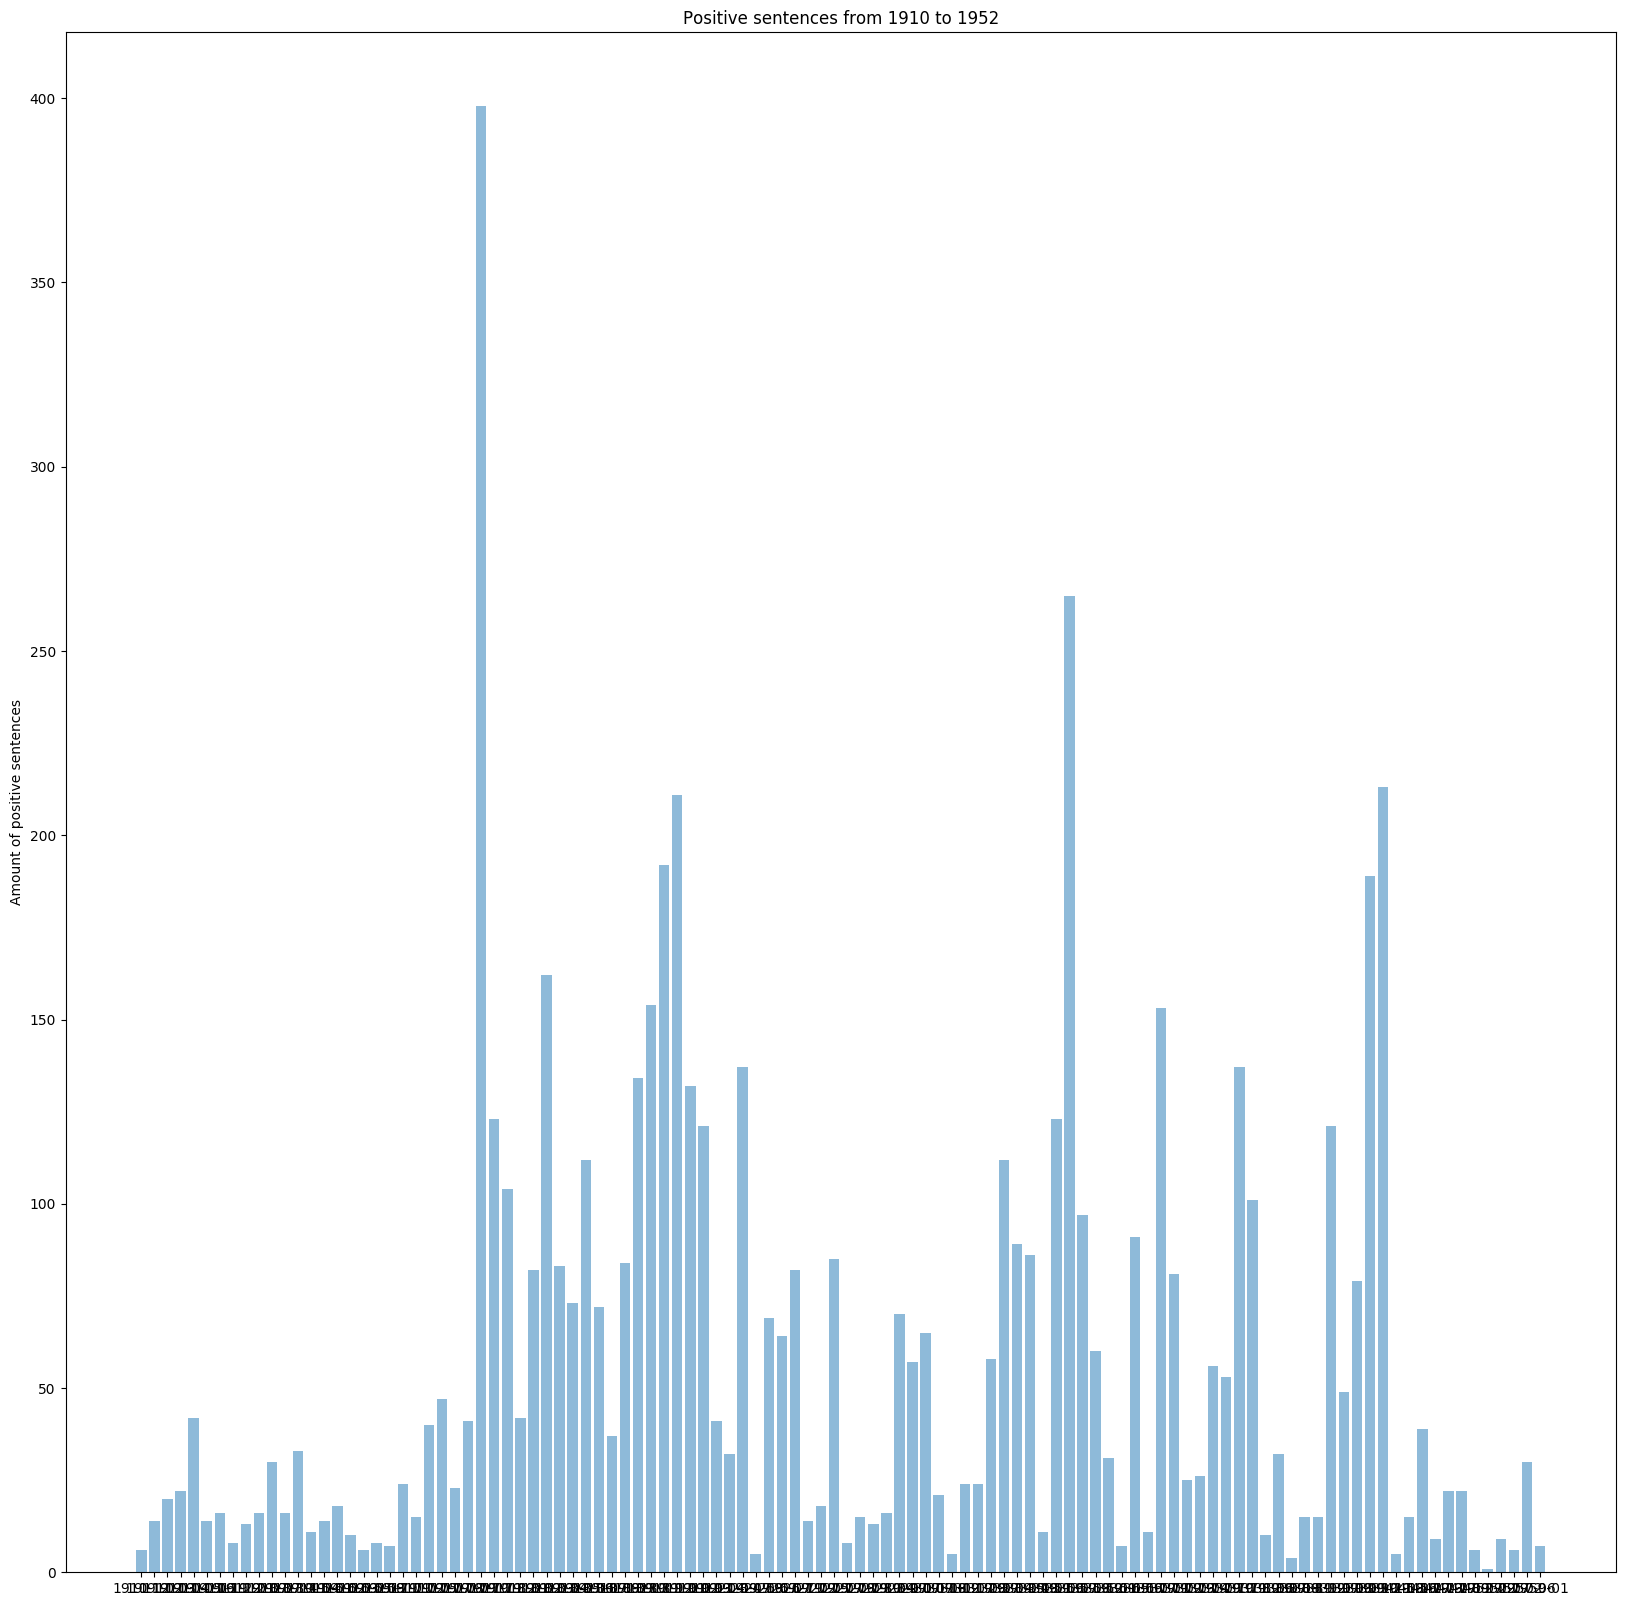

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size
objects = positiveTotal_df['date']
y_pos = np.arange(len(objects))
performance = positiveTotal_df['totalPositive']

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Amount of positive sentences')
plt.title('Positive sentences from 1910 to 1952')

plt.show()


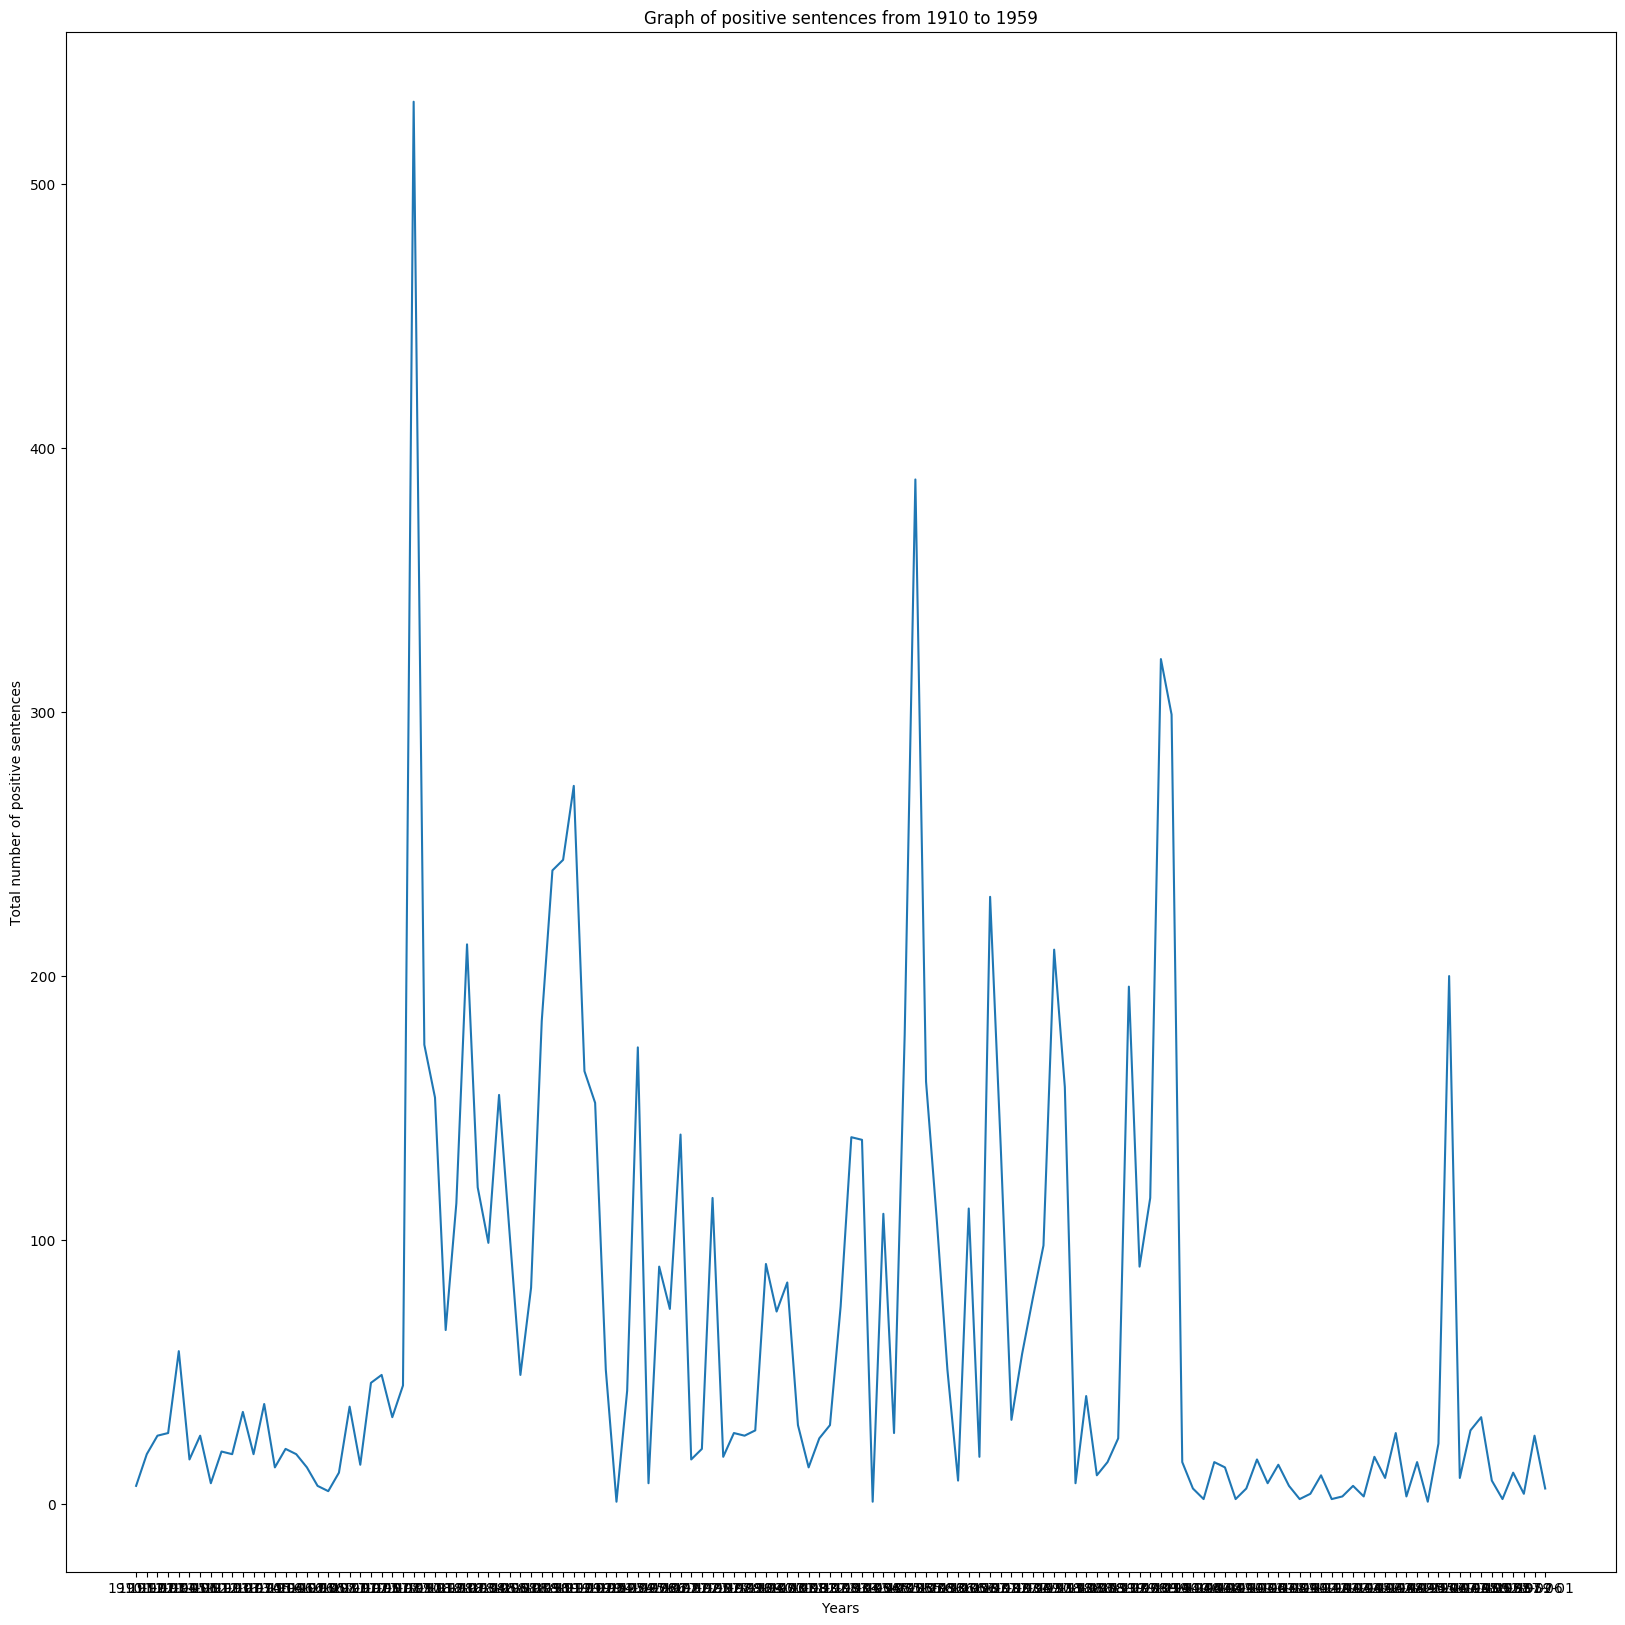

In [0]:
# importing the required module 
import matplotlib.pyplot as plt 
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size
# x axis values 
x = positiveTotal_df['date'] 
# corresponding y axis values 
y = positiveTotal_df['totalPositive']
  
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('Years') 
# naming the y axis 
plt.ylabel('Total number of positive sentences') 
  
# giving a title to my graph 
plt.title('Graph of positive sentences from 1910 to 1959') 
  
# function to show the plot 
plt.show() 

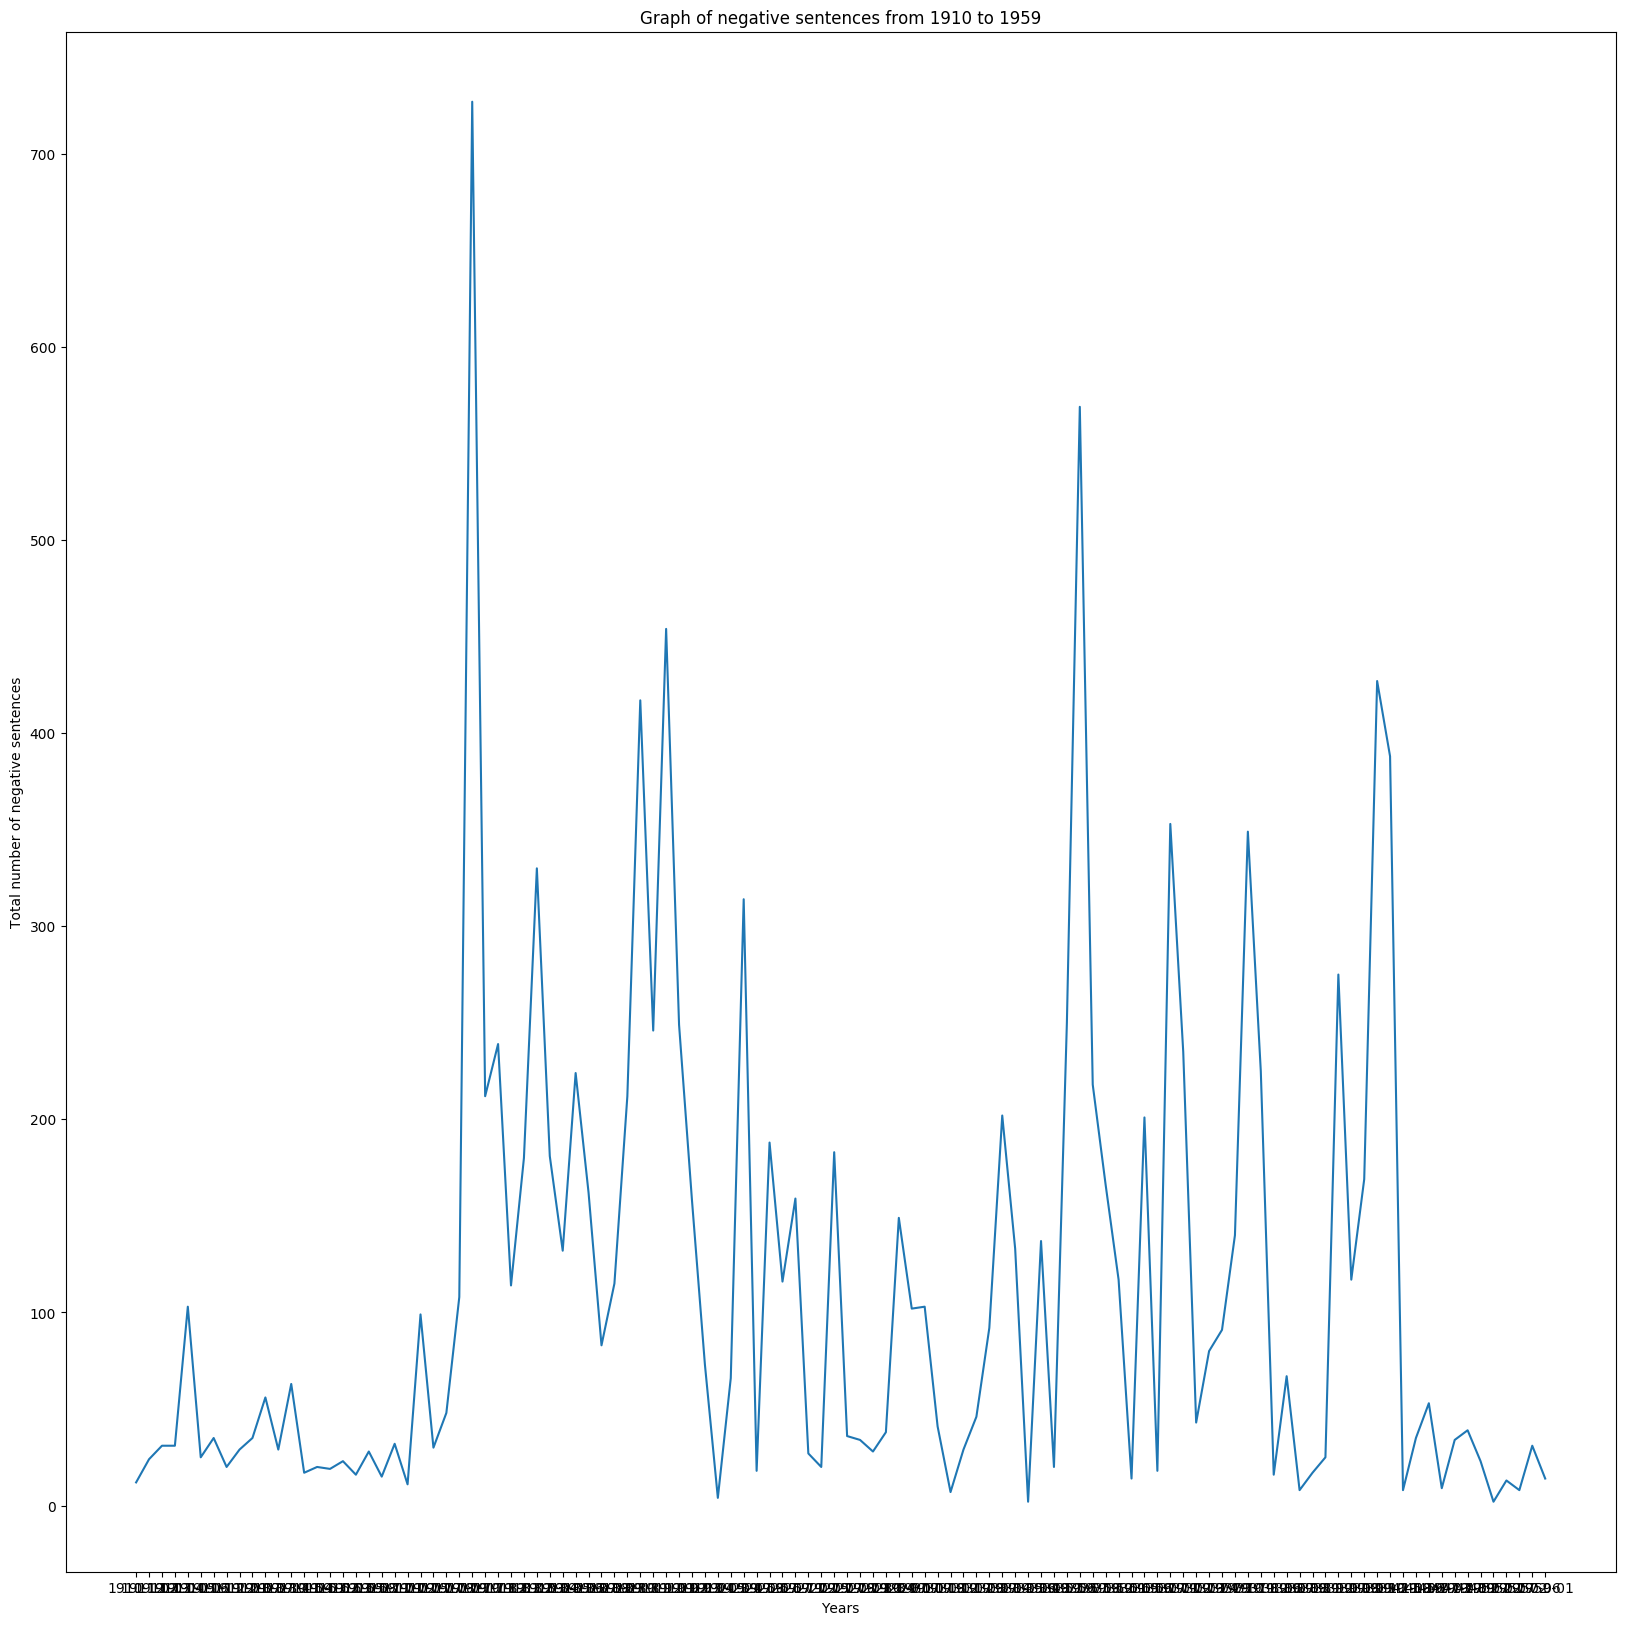

In [0]:
import matplotlib.pyplot as plt 

# x axis values 
x = negativeTotal_df['date'] 
# corresponding y axis values 
y = negativeTotal_df['totalNegative']
  
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('Years') 
# naming the y axis 
plt.ylabel('Total number of negative sentences') 
  
# giving a title to my graph 
plt.title('Graph of negative sentences from 1910 to 1959') 

# function to show the plot 
plt.show() 

In [0]:
import plotly.express as px
fig = px.bar(positiveTotal_df, x="date", y="totalPositive")
fig.update_layout(
    title="Positive Sentiment from 1910 to 1959",
    xaxis_title="Date",
    yaxis_title="Amount",

)
fig.show()

In [0]:
username = 'valiantEmpire' # your username
api_key = 'EqNATdVcyes3rh9tioRG' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [0]:
import chart_studio.plotly as py
py.plot(fig, filename = "Positive Sentiment from 1910 to 1959", auto_open=True)

'https://plot.ly/~valiantEmpire/1/'

In [0]:
fig = px.bar(negativeTotal_df, x="date", y="totalNegative")
fig.update_layout(
    title="Negative Sentiment from 1910 to 1959",
    xaxis_title="Date",
    yaxis_title="Amount",
)
fig.show()

In [0]:
py.plot(fig, filename = "Negative Sentiment from 1910 to 1959", auto_open=True)

'https://plot.ly/~valiantEmpire/3/'

In [0]:
# Create a multi bar graph with positivce and negative overlayed on top of each other
#Do some slides
import plotly.graph_objects as go
posSentiment = positiveTotal_df.totalPositive
negSentiment = negativeTotal_df.totalNegative
date = positiveTotal_df.date
date2 = negativeTotal_df.date
fig = go.Figure(data=[
    go.Bar(name='Positive', x=date, y=posSentiment),
    go.Bar(name='Negative', x=date2, y=negSentiment)
])

#Change names and stuff for the graph
fig.update_layout(
    title="Negative and Postive Sentiment from 1910 to 1959",
    xaxis_title="Date",
    yaxis_title="Amount",
    barmode='stack'
)

fig.show()

In [0]:
py.plot(fig, filename = "Negative and Postive Sentiment from 1910 to 1959", auto_open=True)

'https://plot.ly/~valiantEmpire/5/'

In [0]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=positiveTotal_df.date, y=positiveTotal_df.totalPositive,
                   mode='lines+markers',
                    name='Positive'))
fig.add_trace(go.Scatter(x=negativeTotal_df.date, y=negativeTotal_df.totalNegative,
                    mode='lines+markers',
                    name='Negative'))
fig.update_layout(
    title="Negative and Postive Sentiment from 1910 to 1959",
    xaxis_title="Date",
    yaxis_title="Amount"
)

fig.show()

In [0]:
py.plot(fig, filename = "line_graph", auto_open=True)

'https://plot.ly/~valiantEmpire/7/'

In [0]:
predict_sentiment(model, "He looks awful.")


0.0

In [0]:
predict_sentiment(model, "This affair of Wallace is one of the worst messes I've ever been tangled up in and I hope another one doesn't come up again soon but it undoubtedly will")


0.0

In [0]:
predict_sentiment(model, "There is no solution for the Jewish problem and I fear the crackpots would turn the country over to Stalin if they had half a chance")


0.0

In [0]:
predict_sentiment(model, "We then had a stormy meeting discussing the atomic bomb.")

0.0

In [0]:
predict_sentiment(model, "It was a beautiful Sunday morning.")


1.0

In [0]:
predict_sentiment(model, "Lots of love")


1.0

In [0]:
predict_sentiment(model, "He is sad")


0.0

In [0]:
#torch.save(model.state_dict(), 'sentiment_model.pt')